In [18]:
from astropy.io import fits

In [19]:
from astropy.table import Table

In [20]:
import matplotlib.pyplot as plt

In [21]:
import pandas as pd

In [22]:
from IPython.core.display import display, HTML

TDEs = ['AT2018bsi',
        'AT2018hyz',
        'AT2019azh',
        'AT2020ocn',
        'AT2020wey'
       ]

for t in TDEs:
    display(HTML("""<a href="https://www.wis-tns.org/object/{}">{}</a>""".format(t[2:], t)))

/var/folders/9_/177p01wj5yq421833hg4p2yc0000gn/T/ipykernel_8932/3975346839.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [23]:
from astropy.cosmology import WMAP9 as cosmo

In [24]:
import seaborn as sns
sns.set_context('paper')

base_path = "/Users/mitchell/offcenter_blackholes/data/"

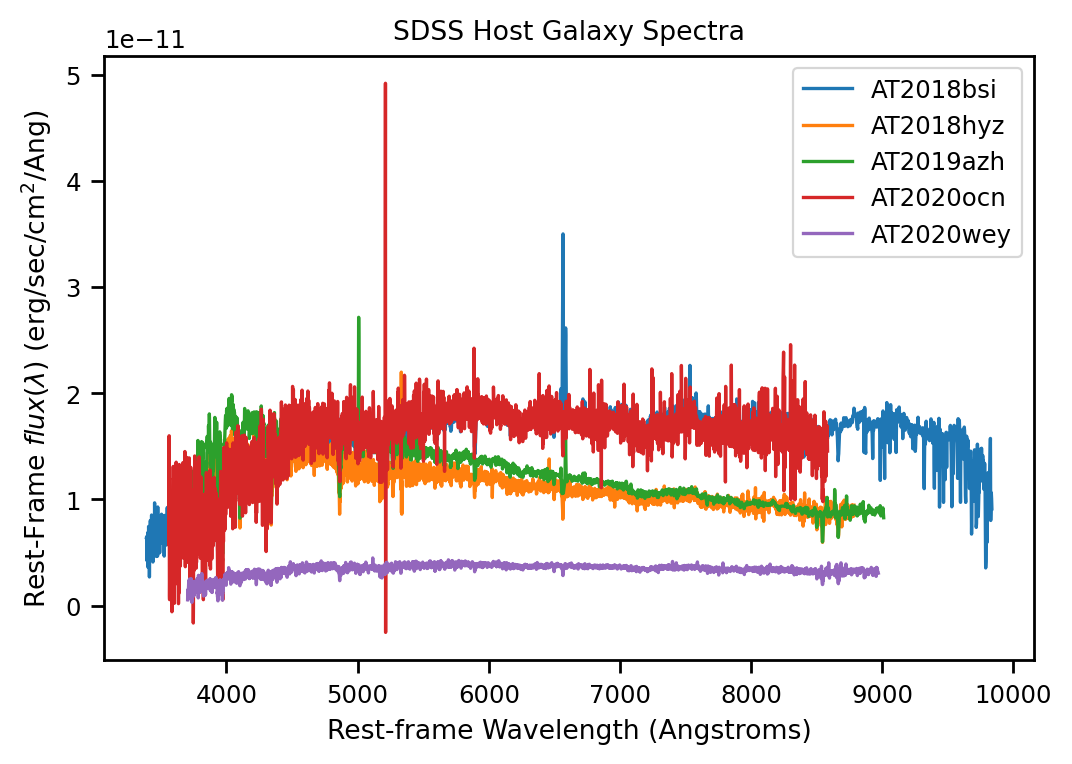

In [73]:
base_path = "/Users/mitchell/offcenter_blackholes/data/"

plt.figure(dpi = 200)
for t in TDEs:
    path = base_path + 'spec-{}-host-sdss.fits'.format(t.lower())
    tde_info = Table.read(path)
    fits_data = fits.open(path) 
    
    spec_meta = Table(fits_data[2].data)
    z = spec_meta['Z']
    
    luminosity_distance = cosmo.luminosity_distance(z)
    f_app = tde_info['flux']*1e-17 * (1 + z)
    f_abs = f_app * luminosity_distance**2
    
    plt.plot(10**tde_info['loglam'] / (1 + z), f_abs, label = t)
    
plt.legend()
plt.xlabel('Rest-frame Wavelength (Angstroms)')
plt.ylabel(f'Rest-Frame $flux(\\lambda)$ (erg/sec/cm$^2$/Ang)')
plt.title('SDSS Host Galaxy Spectra')
plt.savefig('../figures/sdss_host_galaxy_spectra.png')
plt.show()

In [25]:
import sncosmo
import numpy as np

def get_rf_host_spectrum(tde_name):
    """
    Parameters:
    -----------
    tde_name (str): name of TDE whose host we want
    
    Returns:
    --------
    spectrum: sncosmo.Spectrum object
    
    """
    
    path = base_path + 'spec-{}-host-sdss.fits'.format(tde_name.lower())
    tde_info = Table.read(path)
    fits_data = fits.open(path) 
    
    spec_meta = Table(fits_data[2].data)
    z = spec_meta['Z']
    
    luminosity_distance = cosmo.luminosity_distance(z)
    f_app = tde_info['flux']*1e-17 * (1 + z)
    f_abs = f_app * luminosity_distance**2
    
    err_app = np.sqrt(1/tde_info['ivar'])*1e-17 * (1 + z)
    err_abs = err_app * luminosity_distance**2
    
    wave = 10**tde_info['loglam'] / (1 + z)
    
    spectrum = sncosmo.Spectrum(wave, f_abs, err_abs)
    
    return spectrum

In [26]:
roman_filters = ['f062', 'f087', 'f106', 
                 'f129', 'f158', 'f184', 
                 'f213', 'f146'
                ]

/var/folders/9_/177p01wj5yq421833hg4p2yc0000gn/T/ipykernel_8932/2785285908.py:27: RuntimeWarning: divide by zero encountered in true_divide
  err_app = np.sqrt(1/tde_info['ivar'])*1e-17 * (1 + z)


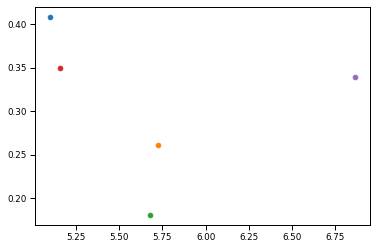

In [27]:
spectra = [get_rf_host_spectrum(t) for t in TDEs]

for spectrum in spectra:
    g_mag, i_mag = spectrum.bandmag(['sdssr', 'sdssi'], 'ab')
    plt.scatter(i_mag,  g_mag - i_mag)

In [28]:
import sys
sys.path.append('../')
from scripts import tde_utils

at2018hyz = {'u_mag': 19.195, 'err_u': 0.034,
           'g_mag': 17.605, 'err_g': 0.005,
           'r_mag': 17.040, 'err_r': 0.005,
           'i_mag': 16.755, 'err_i': 0.005,
           'z_mag': 16.546, 'err_z': 0.0014,
            'z':  0.0457}

at2018hyz_mag = {'sdss_u0': (at2018hyz['u_mag'], at2018hyz['err_u']),
           'sdss_g0': (at2018hyz['g_mag'], at2018hyz['err_g']),
           'sdss_r0': (at2018hyz['r_mag'], at2018hyz['err_r']),
           'sdss_i0': (at2018hyz['i_mag'], at2018hyz['err_i']),
           'sdss_z0': (at2018hyz['z_mag'], at2018hyz['err_z'])}

# gal = tde_utils.GalaxySource(mag_dict = at2018hyz_mag, obs_z = at2018hyz['z'])
# gal_model = sncosmo.Model(source=gal)

In [29]:
def make_mag_dict(spectrum):
    
    mag_dict = {}
    bandnames = [('sdss_u0', 'sdssu'),
                 ('sdss_g0', 'sdssg'),
                 ('sdss_r0', 'sdssr'),
                 ('sdss_i0', 'sdssi'),
                 ('sdss_z0', 'sdssz')
                ]
    for band in bandnames:
        try:
            bandmag = spectrum.bandmag(band[1], 'ab')
            mag_dict[band[0]] = (bandmag, 0.01)
        except Exception as err:
            #do nothing
            print(f"Unexpected {err=}, {type(err)=}")
    return mag_dict

In [30]:
import sncosmo
import numpy as np

def get_obs_host_spectrum(tde_name):
    """
    Parameters:
    -----------
    tde_name (str): name of TDE whose host we want
    
    Returns:
    --------
    spectrum: sncosmo.Spectrum object
    
    """
    
    path = base_path + 'spec-{}-host-sdss.fits'.format(tde_name.lower())
    tde_info = Table.read(path)
    fits_data = fits.open(path) 
    
    spec_meta = Table(fits_data[2].data)
    z = spec_meta['Z']
    
    luminosity_distance = cosmo.luminosity_distance(z)
    f_app = tde_info['flux']*1e-17
    
    err_app = np.sqrt(1/tde_info['ivar'])*1e-17    
    wave = 10**tde_info['loglam']
    
    spectrum = sncosmo.Spectrum(wave, f_app, err_app)
    
    return spectrum, z

In [31]:
at2018bsi_mag = {'sdss_u0': (17.735, 0.020),
            'sdss_g0': (16.178, 0.004),
            'sdss_r0': (15.384, 0.003),
            'sdss_i0': (14.952, 0.003),
            'sdss_z0': (14.608, 0.006)
           }

at2019azh_mag = {'sdss_u0': (16.489, 0.008),
            'sdss_g0': (14.998, 0.002),
            'sdss_r0': (14.492, 0.002),
            'sdss_i0': (14.259, 0.002),
            'sdss_z0': (14.101, 0.004)
           }

at2020ocn_mag = {'sdss_u0': (20.101, 0.064),
            'sdss_g0': (18.247, 0.008),
            'sdss_r0': (17.459, 0.006),
            'sdss_i0': (17.074, 0.006),
            'sdss_z0': (16.811, 0.015)
           }

at2020wey_mag = {'sdss_u0': (18.719, 0.031),
            'sdss_g0': (17.192, 0.005),
            'sdss_r0': (16.504, 0.004),
            'sdss_i0': (16.173, 0.005),
            'sdss_z0': (15.931, 0.011)
           }
mag_dicts = [at2018bsi_mag, 
             at2018hyz_mag, 
             at2019azh_mag, 
             at2020ocn_mag, 
             at2020wey_mag
            ]

In [32]:
def get_obs_host_spectrum(tde_name):
    """
    Parameters:
    -----------
    tde_name (str): name of TDE whose host we want
    
    Returns:
    --------
    spectrum: sncosmo.Spectrum object
    
    """
    
    path = base_path + 'spec-{}-host-sdss.fits'.format(tde_name.lower())
    tde_info = Table.read(path)
    fits_data = fits.open(path) 
    
    spec_meta = Table(fits_data[2].data)
    z = spec_meta['Z']
    
    luminosity_distance = cosmo.luminosity_distance(z)
    f_app = tde_info['flux']*1e-17
    
    err_app = np.sqrt(1/tde_info['ivar'])*1e-17    
    wave = 10**tde_info['loglam']
    
    spectrum = sncosmo.Spectrum(wave, f_app, err_app)
    
    return spectrum, z


/var/folders/9_/177p01wj5yq421833hg4p2yc0000gn/T/ipykernel_8690/3678235396.py:23: RuntimeWarning: divide by zero encountered in true_divide
  err_app = np.sqrt(1/tde_info['ivar'])*1e-17


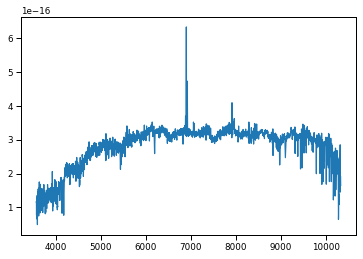

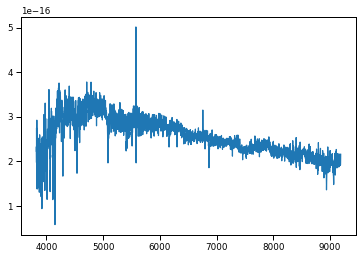

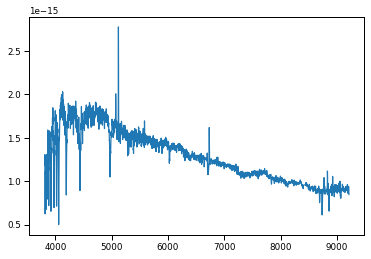

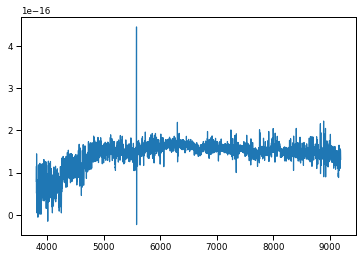

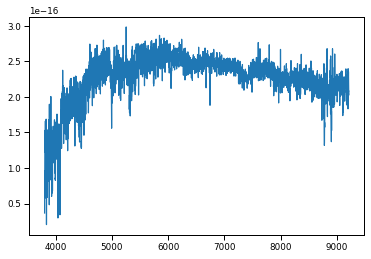

In [22]:
for i, specz in enumerate([get_obs_host_spectrum(t) for t in TDEs]):
    spectrum, z  = specz
#     mag_dict = mag_dicts[i]
#     z = z.value[0]
#     gal = tde_utils.GalaxySource(mag_dict = mag_dict, obs_z = z)
#     gal_model = sncosmo.Model(source=gal)
#     gal_model.set(z=z)
    
    plt.plot(spectrum.wave, spectrum.flux)
    plt.show()

In [33]:
from astropy import units as u

/var/folders/9_/177p01wj5yq421833hg4p2yc0000gn/T/ipykernel_8932/3678235396.py:23: RuntimeWarning: divide by zero encountered in true_divide
  err_app = np.sqrt(1/tde_info['ivar'])*1e-17


mag dict: {'sdss_u0': (17.735, 0.02), 'sdss_g0': (16.178, 0.004), 'sdss_r0': (15.384, 0.003), 'sdss_i0': (14.952, 0.003), 'sdss_z0': (14.608, 0.006)}
[-19.30428352 -20.78925847 -21.55648669 -21.93637526 -22.29049627]
modelled mags: [ 17.64932022  16.12761161  15.33344194  14.89927608  14.56718805]


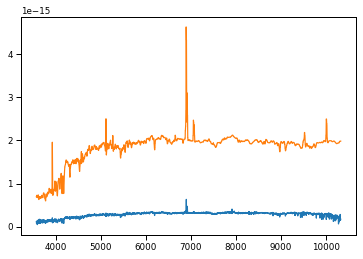

mag dict: {'sdss_u0': (19.195, 0.034), 'sdss_g0': (17.605, 0.005), 'sdss_r0': (17.04, 0.005), 'sdss_i0': (16.755, 0.005), 'sdss_z0': (16.546, 0.0014)}
[-17.61652353 -19.07071531 -19.65377068 -19.83109326 -20.0716866 ]
modelled mags: [ 19.03112565  17.5538728   16.9954993   16.69624207  16.50333621]


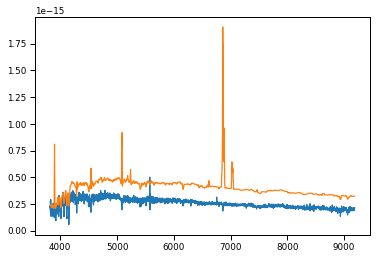

mag dict: {'sdss_u0': (16.489, 0.008), 'sdss_g0': (14.998, 0.002), 'sdss_r0': (14.492, 0.002), 'sdss_i0': (14.259, 0.002), 'sdss_z0': (14.101, 0.004)}
[-18.61955337 -20.03374625 -20.5451473  -20.74233168 -20.90230139]
modelled mags: [ 16.32187029  14.96379614  14.41575827  14.22301039  14.02786242]


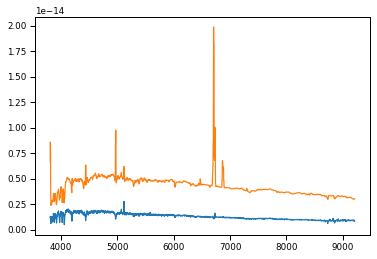

mag dict: {'sdss_u0': (20.101, 0.064), 'sdss_g0': (18.247, 0.008), 'sdss_r0': (17.459, 0.006), 'sdss_i0': (17.074, 0.006), 'sdss_z0': (16.811, 0.015)}
[-17.75651274 -19.51218955 -20.21689798 -20.52890649 -20.80583169]
modelled mags: [ 19.84719402  18.21966668  17.39119387  17.0282282   16.77259723]


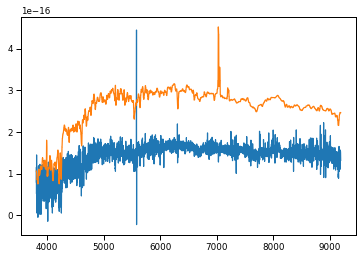

mag dict: {'sdss_u0': (18.719, 0.031), 'sdss_g0': (17.192, 0.005), 'sdss_r0': (16.504, 0.004), 'sdss_i0': (16.173, 0.005), 'sdss_z0': (15.931, 0.011)}
[-16.84235298 -18.32856409 -18.99347081 -19.30668771 -19.54401193]
modelled mags: [ 18.57954978  17.14925432  16.43791709  16.12421259  15.87757451]


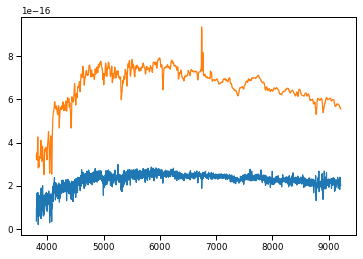

In [35]:
for i, specz in enumerate([get_obs_host_spectrum(t) for t in TDEs]):
    spectrum, z  = specz
    mag_dict = mag_dicts[i]
    print('mag dict:', mag_dict)
    z = z.value[0]
    gal = tde_utils.GalaxySource(mag_dict = mag_dict, obs_z = z)
    gal_model = sncosmo.Model(source=gal)
    gal_model.set(z=z)
    
    plt.plot(spectrum.wave, spectrum.flux)
    luminosity_distance = cosmo.luminosity_distance(z).to(u.parsec)
    mod_mags = gal_model.bandmag(['sdssu', 'sdssg', 'sdssr', 'sdssi', 'sdssz'], 'ab', 0) + 5*np.log10(luminosity_distance/(10 * u.parsec))
    print('modelled mags:', mod_mags)
    gal_flux = gal_model.flux(time=0, wave=spectrum.wave) * 100 / (luminosity_distance**2)
    plt.plot(spectrum.wave, gal_flux / (1+z))
    plt.show()

In [95]:
gal_model.minwave(), gal_model.maxwave()

(600.257568359375, 3198626.25)

In [96]:
gal._wave

array([  6.00257568e+02,   6.00772888e+02,   6.01288696e+02, ...,
         3.19314100e+06,   3.19588250e+06,   3.19862625e+06], dtype=float32)

In [104]:
[get_rf_host_spectrum(t) for t in TDEs]

/var/folders/9_/177p01wj5yq421833hg4p2yc0000gn/T/ipykernel_896/2785285908.py:27: RuntimeWarning: divide by zero encountered in true_divide
  err_app = np.sqrt(1/tde_info['ivar'])*1e-17 * (1 + z)


In [46]:
for hdu in spec_info:
    print(hdu.data)

None
[( 3.6687975, 3.5804, 0.0400557 , 71303168,  71303168, 1.163659 , 6.550594 , 13.106703)
 ( 7.0738945, 3.5805, 0.09639911,        0, 201326592, 1.1632967, 6.891371 , 12.759462)
 ( 3.7455022, 3.5806, 0.10210862,        0, 202375168, 1.1628956, 6.8466396, 12.362778)
 ...
 (20.810177 , 3.9643, 0.50194573,        0,         0, 0.6880424, 5.897491 , 20.600819)
 (20.83999  , 3.9644, 0.48162672,        0,         0, 0.6883025, 6.6744184, 20.654829)
 (20.308153 , 3.9645, 0.45868415,        0,         0, 0.6885638, 7.6962957, 20.615108)]
[('sdss', 'SDSS', 'chunk93', 'legacy', 'dr2004.03.3', 'good', 17.942, 0., 5000., -1, 0., -9999., -1, 1, 1, 0, 0, 0, 0, 0, '   2010988974796990464', '1237663531337777270', '1237663531337777270', '     11277057809449094', '2010857308279564288', 1, 'dr7', '26', '', -1, -0.3419393, 0.32610531, 0.88132448, -99.9696, 99.87107, 'GALAXY', 'SCIENCE', 64, 0, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1786, 1291, 54450, 479, [4204,   40,    5,  216,  134], 136.3577